In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/python_modules')
sys.path.insert(1,'/content/drive/My Drive/data_files')

In [3]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy.stats import norm

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Utill-Class

In [5]:
from EDA import EDA
from GradientDescent import GradientDescent

# Read Data

In [6]:
data = pd.read_csv('/content/drive/MyDrive/data_files/weather.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        366 non-null    float64
 1   MaxTemp        366 non-null    float64
 2   Rainfall       366 non-null    float64
 3   Evaporation    366 non-null    float64
 4   Sunshine       363 non-null    float64
 5   WindGustDir    363 non-null    object 
 6   WindGustSpeed  364 non-null    float64
 7   WindDir9am     335 non-null    object 
 8   WindDir3pm     365 non-null    object 
 9   WindSpeed9am   359 non-null    float64
 10  WindSpeed3pm   366 non-null    int64  
 11  Humidity9am    366 non-null    int64  
 12  Humidity3pm    366 non-null    int64  
 13  Pressure9am    366 non-null    float64
 14  Pressure3pm    366 non-null    float64
 15  Cloud9am       366 non-null    int64  
 16  Cloud3pm       366 non-null    int64  
 17  Temp9am        366 non-null    float64
 18  Temp3pm   

In [7]:
data.isna().sum()

MinTemp           0
MaxTemp           0
Rainfall          0
Evaporation       0
Sunshine          3
WindGustDir       3
WindGustSpeed     2
WindDir9am       31
WindDir3pm        1
WindSpeed9am      7
WindSpeed3pm      0
Humidity9am       0
Humidity3pm       0
Pressure9am       0
Pressure3pm       0
Cloud9am          0
Cloud3pm          0
Temp9am           0
Temp3pm           0
RainToday         0
RISK_MM           0
RainTomorrow      0
dtype: int64

# EDA

In [8]:
np.random.seed(42)

In [9]:
data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes,39.8,Yes
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,Yes,2.8,Yes
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,Yes,0.0,No


In [10]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,366.000000,366.000000,366.000000,366.000000,363.000000,364.000000,359.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,7.265574,20.550273,1.428415,4.521858,7.909366,39.840659,9.651811,17.986339,72.035519,44.519126,1019.709016,1016.810383,3.890710,4.024590,12.358470,19.230874,1.428415
std,6.025800,6.690516,4.225800,2.669383,3.481517,13.059807,7.951929,8.856997,13.137058,16.850947,6.686212,6.469422,2.956131,2.666268,5.630832,6.640346,4.225800
min,-5.300000,7.600000,0.000000,0.200000,0.000000,13.000000,0.000000,0.000000,36.000000,13.000000,996.500000,996.800000,0.000000,0.000000,0.100000,5.100000,0.000000
25%,2.300000,15.025000,0.000000,2.200000,5.950000,31.000000,6.000000,11.000000,64.000000,32.250000,1015.350000,1012.800000,1.000000,1.000000,7.625000,14.150000,0.000000
50%,7.450000,19.650000,0.000000,4.200000,8.600000,39.000000,7.000000,17.000000,72.000000,43.000000,1020.150000,1017.400000,3.500000,4.000000,12.550000,18.550000,0.000000
75%,12.500000,25.500000,0.200000,6.400000,10.500000,46.000000,13.000000,24.000000,81.000000,55.000000,1024.475000,1021.475000,7.000000,7.000000,17.000000,24.000000,0.200000
max,20.900000,35.800000,39.800000,13.800000,13.600000,98.000000,41.000000,52.000000,99.000000,96.000000,1035.700000,1033.200000,8.000000,8.000000,24.700000,34.500000,39.800000


In [11]:
data['RainTomorrow'].value_counts()

No     300
Yes     66
Name: RainTomorrow, dtype: int64

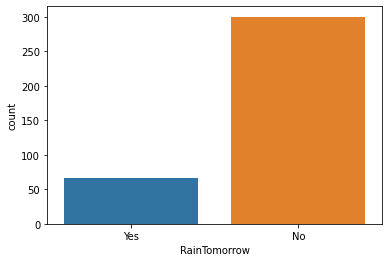

In [12]:
sns.countplot(x=data['RainTomorrow']);

## 1- Split data into train and test

In [13]:
train_data, test_data = train_test_split(data, test_size=.2, random_state=42, stratify=data['RainTomorrow'])

In [14]:
train_data['RainTomorrow'].value_counts()

No     239
Yes     53
Name: RainTomorrow, dtype: int64

In [15]:
test_data['RainTomorrow'].value_counts()

No     61
Yes    13
Name: RainTomorrow, dtype: int64

## 2- Load data in the class

In [16]:
Weather = EDA(train_data=train_data, test_data=test_data, target='RainTomorrow', skip='RainToday')

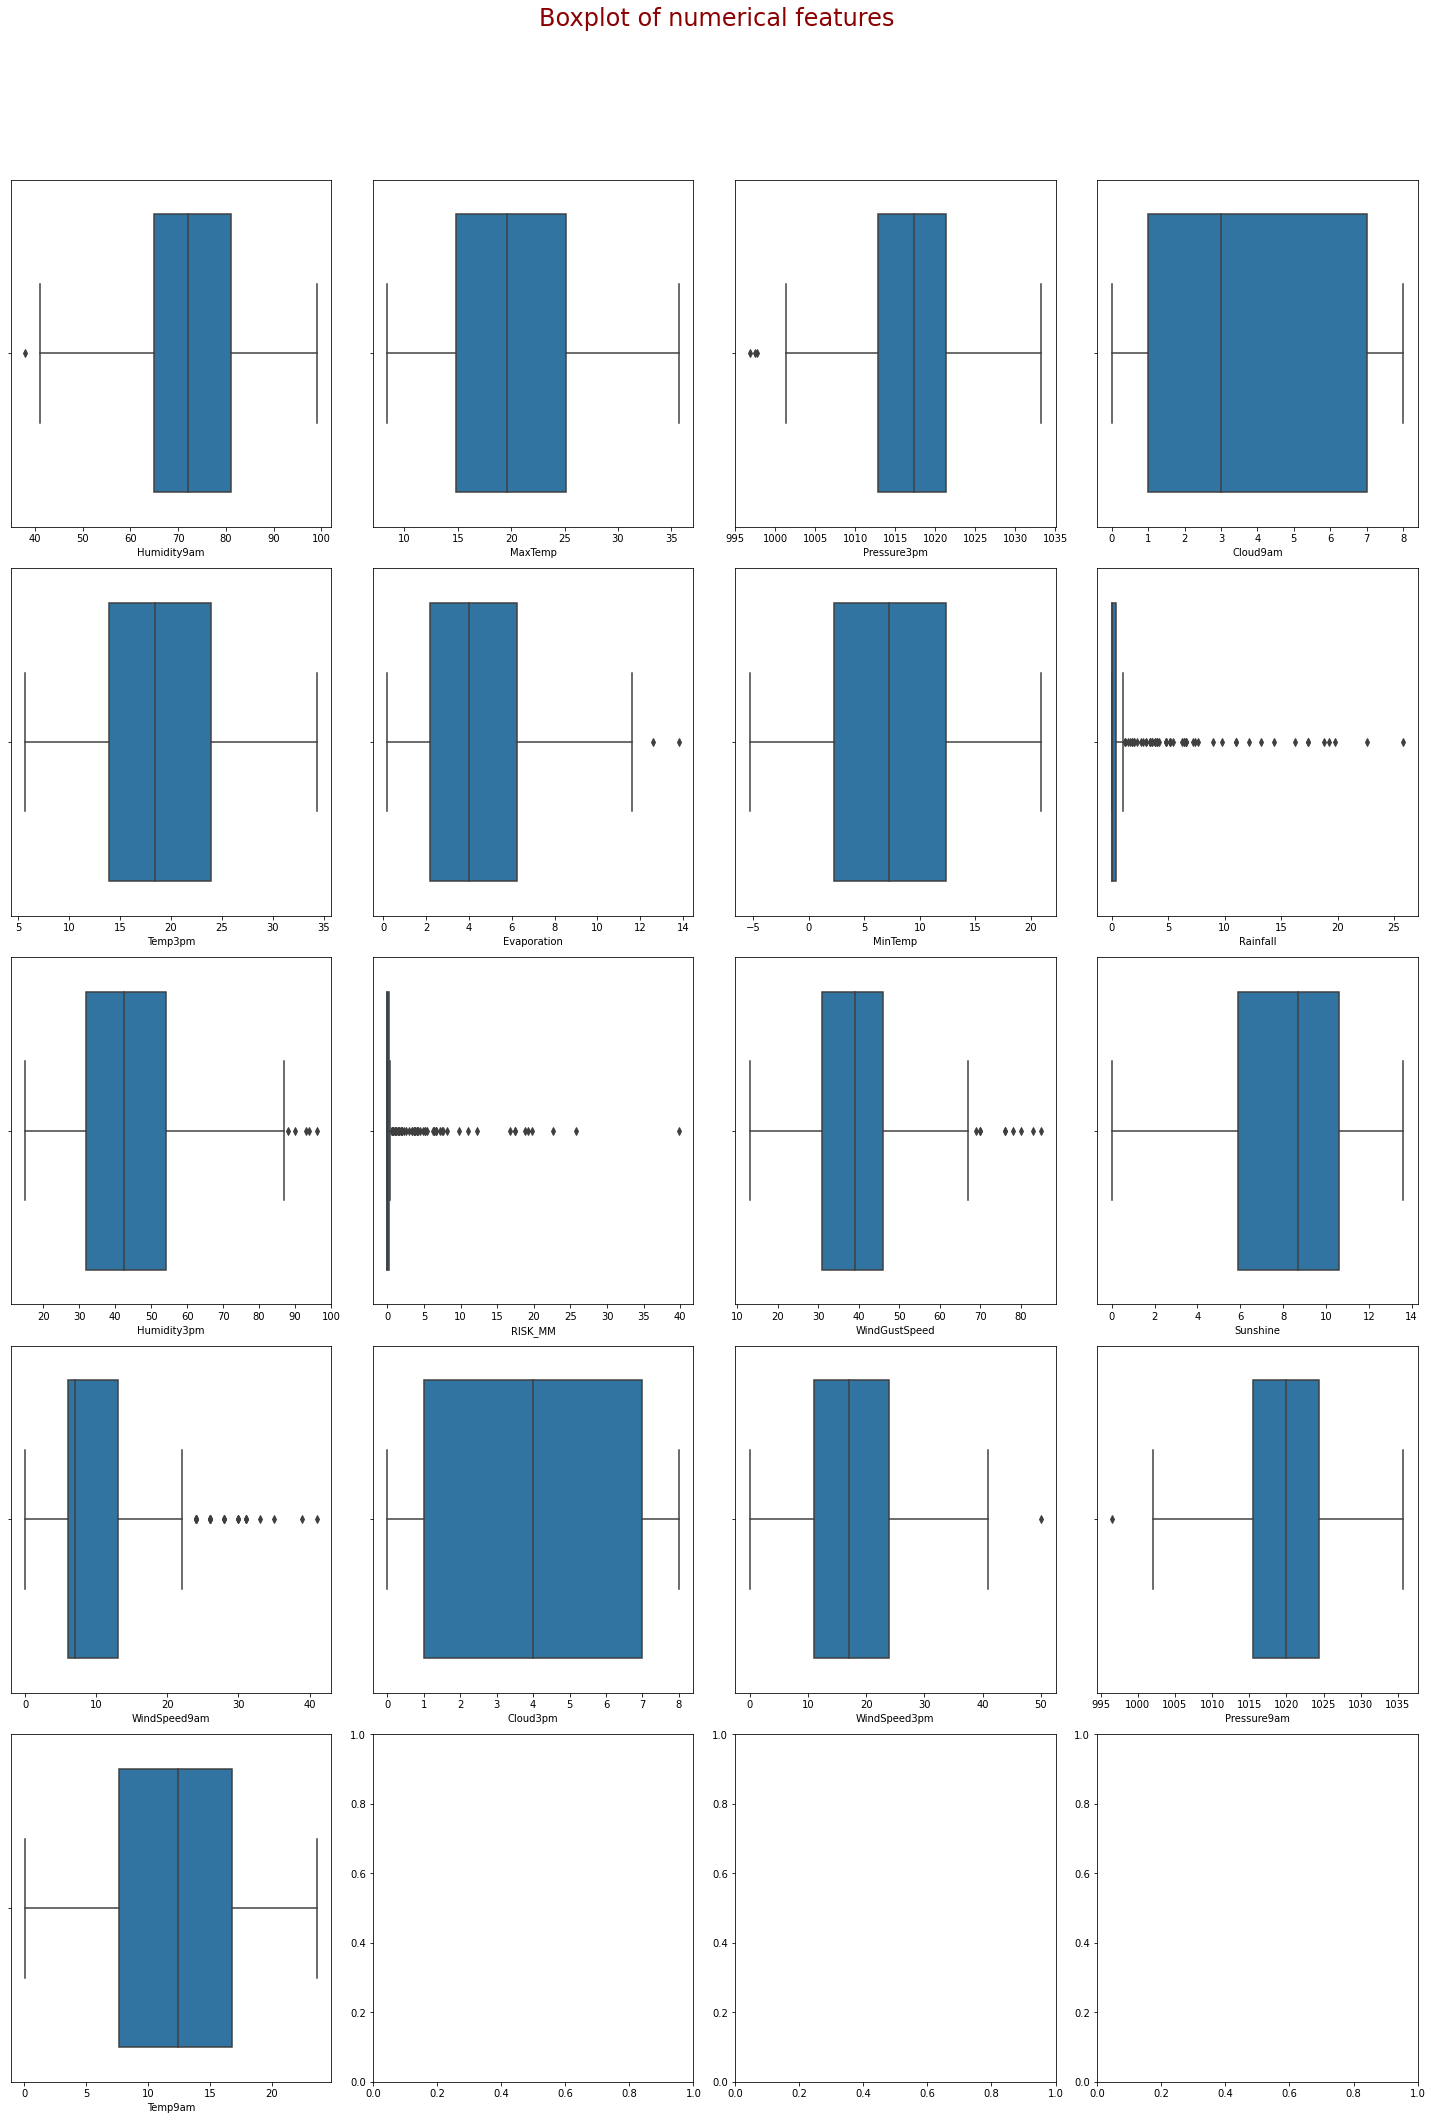

In [17]:
Weather.visualize('boxplot')

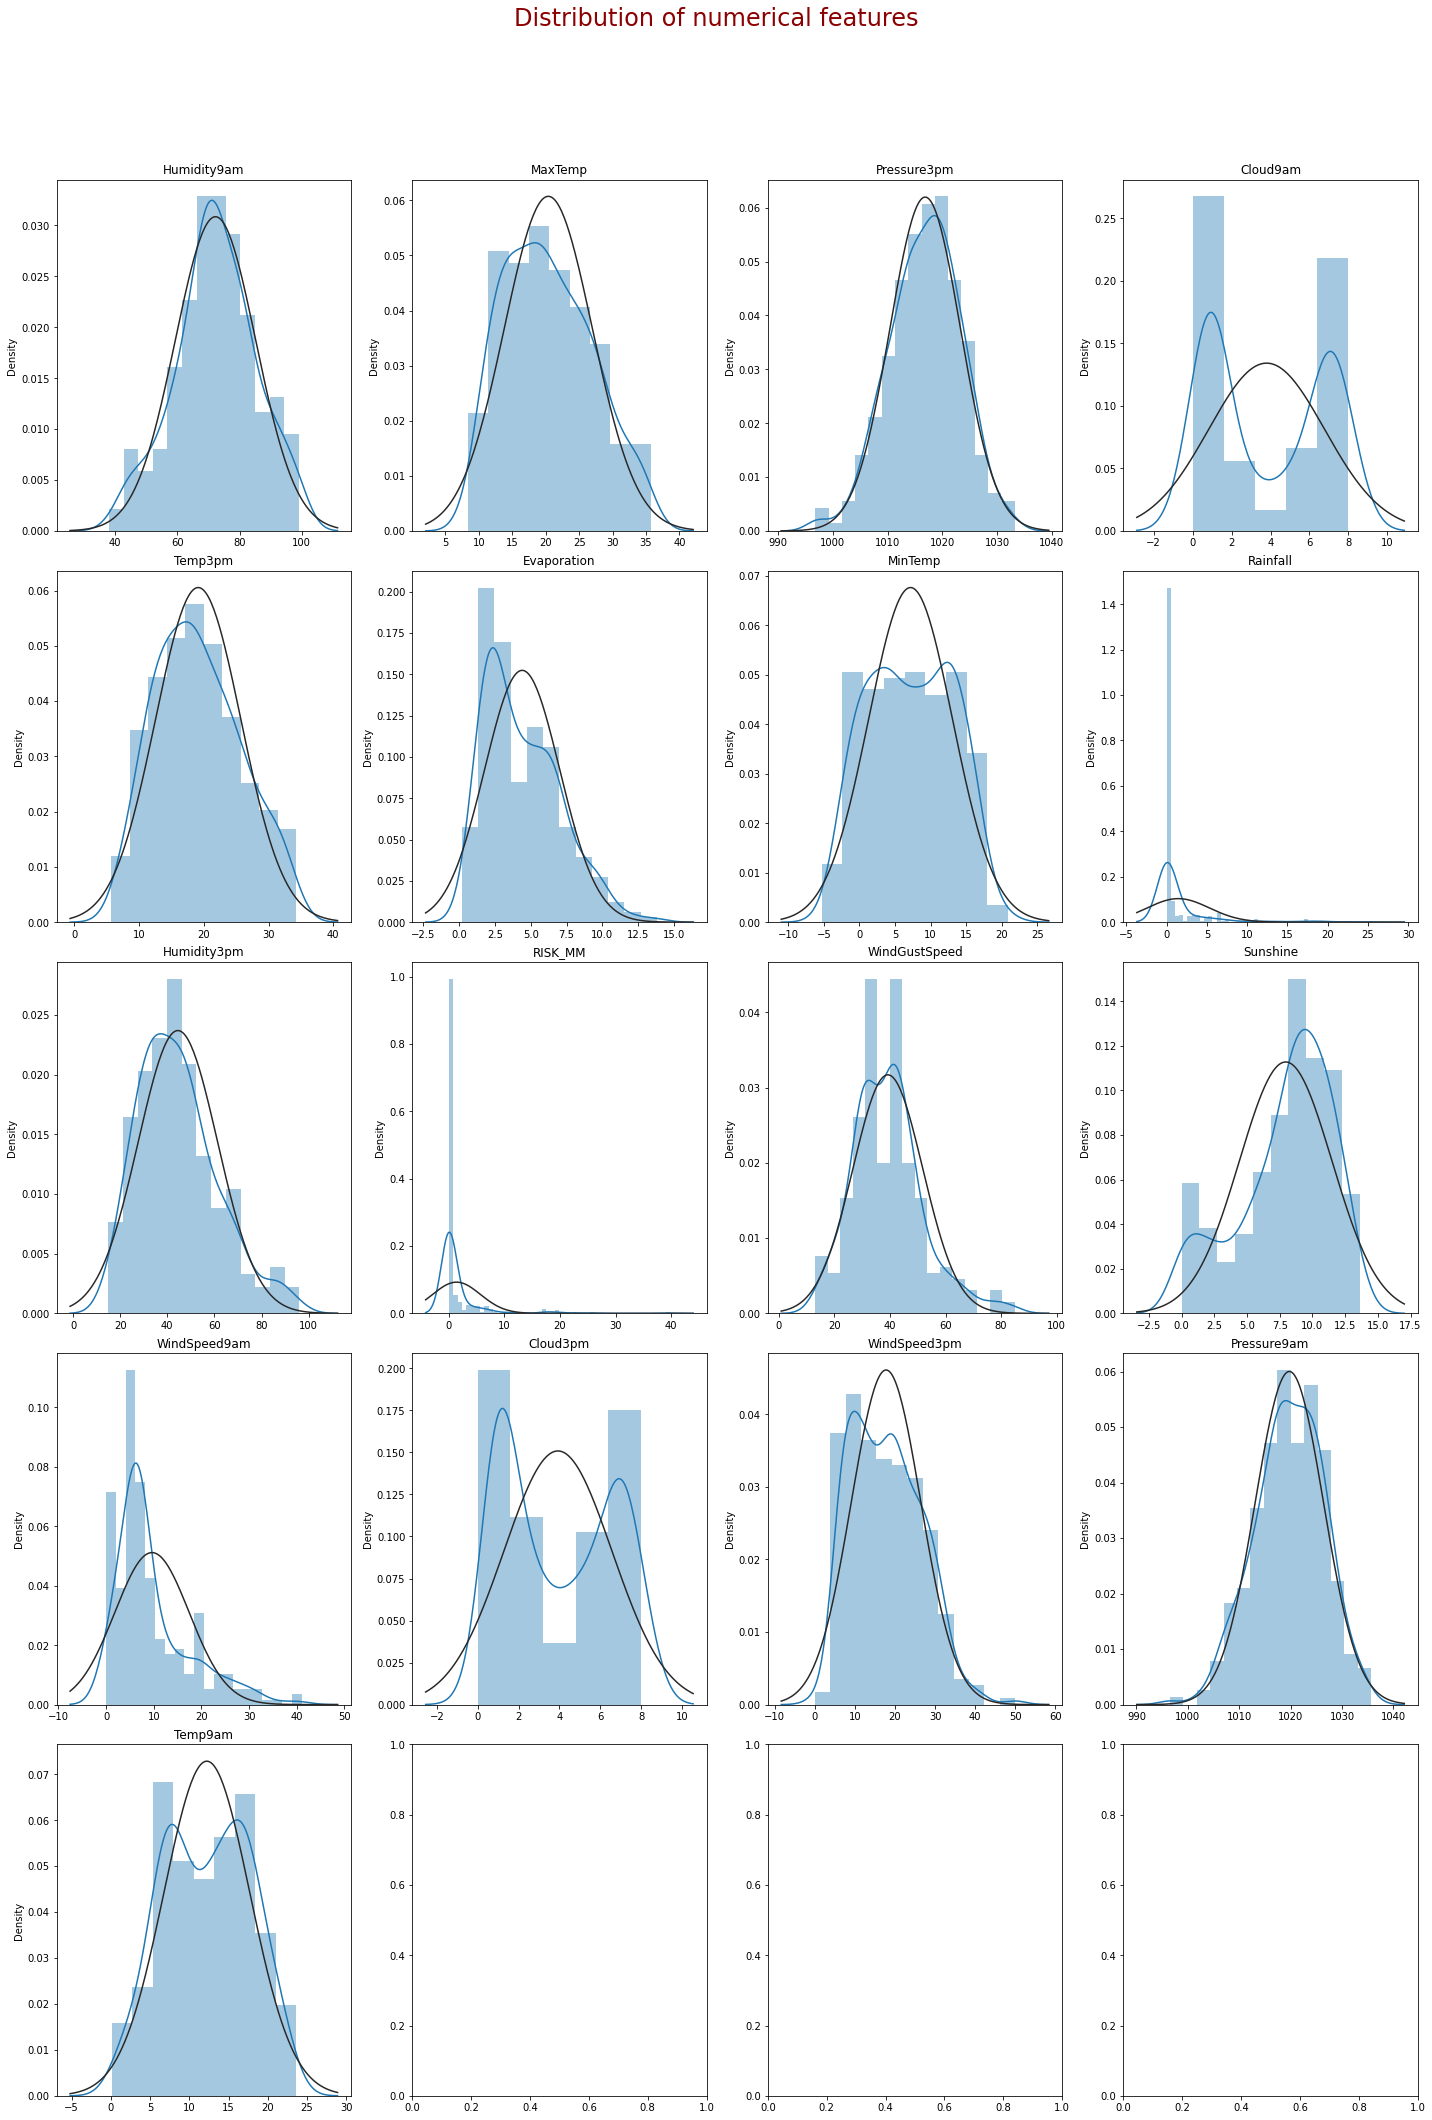

In [18]:
Weather.visualize('dist')

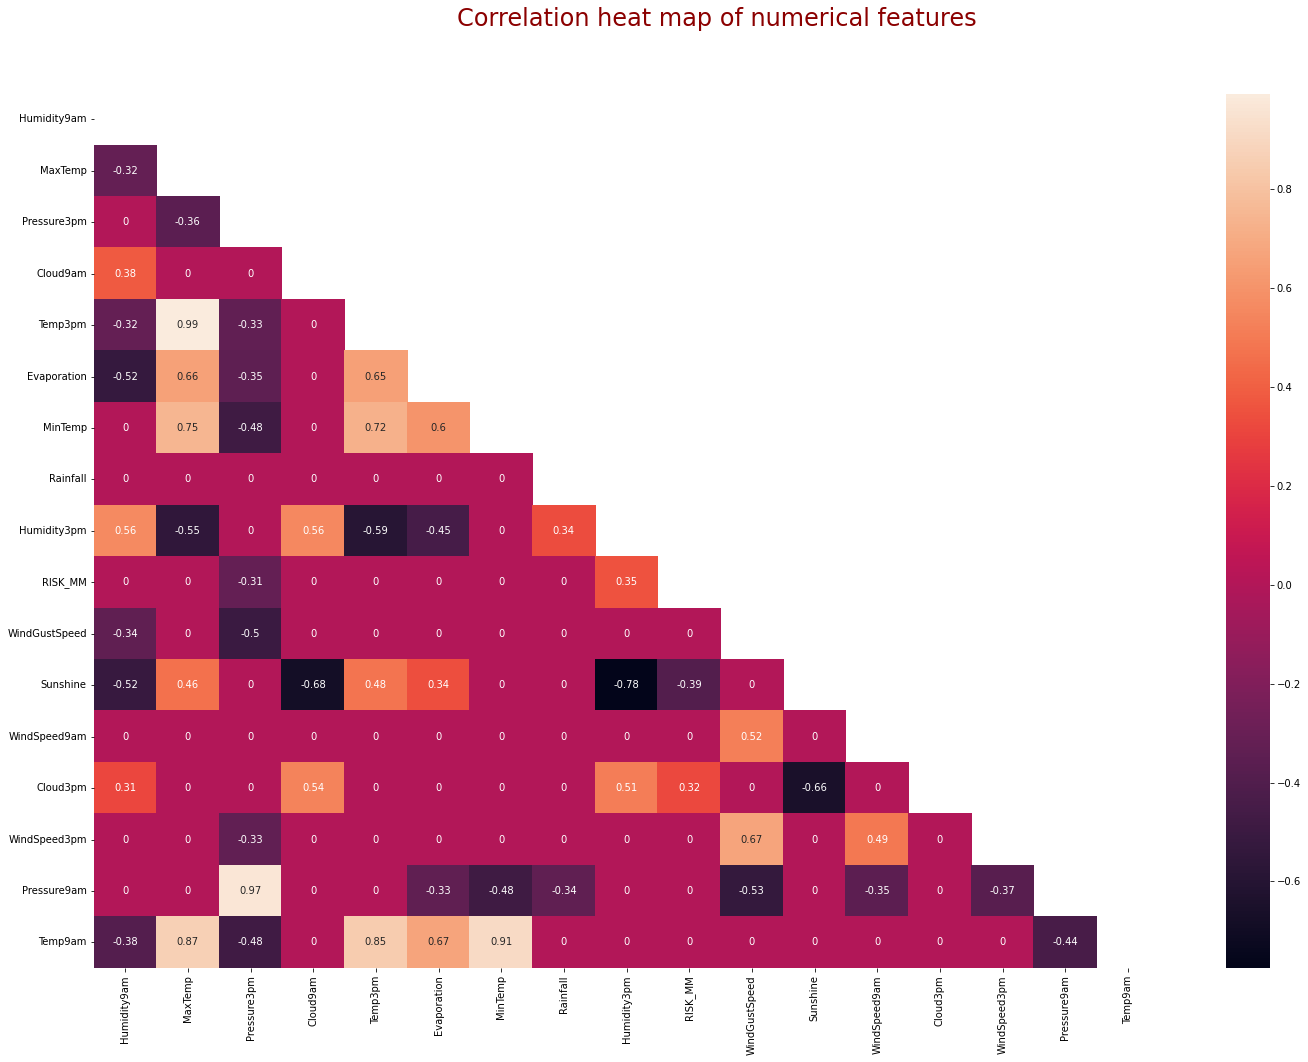

In [19]:
Weather.visualize('corr')

Skipped cols in count plot due to values > 100: 
 []


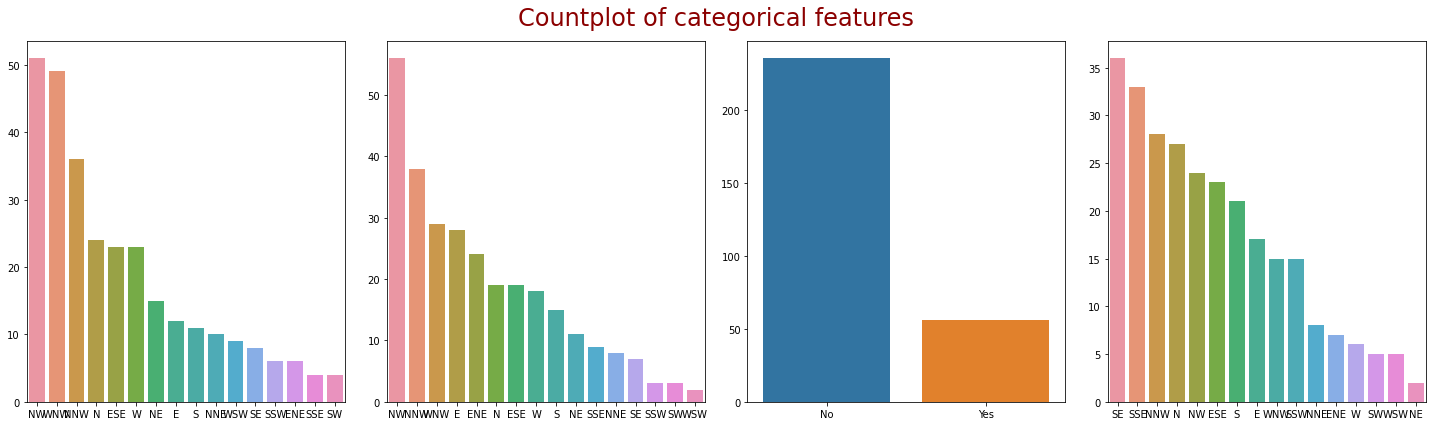

In [20]:
Weather.visualize('countplot')

# Pre-Processing

## Data Pre-processing 
1- Handling Null Values

2- Dropping Features which have more than 80% of values with the same value

3- removing highly correlated features to avoid multi-collinearity as much as we can

4- removing/clamping outliers

5- transforming highly skewed data to reduce their skewness

6- checking for each features whether it follows a normal distribution or not to decide whether to standardize or min-max scale)

7- classify your categorical features into (ordinal and nominal) to decide which features will be label encoded and which features should be OHE

In [21]:
train_data.shape

(292, 22)

## 1- Handling Nulls

In [22]:
Weather.grabNulls()

(Empty DataFrame
 Columns: [index, Null Count]
 Index: [],            index  Null Count
 7     WindDir9am          20
 9   WindSpeed9am           6
 4       Sunshine           3
 5    WindGustDir           3
 6  WindGustSpeed           2
 8     WindDir3pm           1, Empty DataFrame
 Columns: [index, Null Count]
 Index: [])

In [23]:
Weather.handleNulls(rthreshold=.05)

In [24]:
Weather.train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 100 to 156
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        279 non-null    float64
 1   MaxTemp        279 non-null    float64
 2   Rainfall       279 non-null    float64
 3   Evaporation    279 non-null    float64
 4   Sunshine       279 non-null    float64
 5   WindGustDir    279 non-null    object 
 6   WindGustSpeed  279 non-null    float64
 7   WindDir9am     279 non-null    object 
 8   WindDir3pm     279 non-null    object 
 9   WindSpeed9am   279 non-null    float64
 10  WindSpeed3pm   279 non-null    int64  
 11  Humidity9am    279 non-null    int64  
 12  Humidity3pm    279 non-null    int64  
 13  Pressure9am    279 non-null    float64
 14  Pressure3pm    279 non-null    float64
 15  Cloud9am       279 non-null    int64  
 16  Cloud3pm       279 non-null    int64  
 17  Temp9am        279 non-null    float64
 18  Temp3pm 

## 2- Handle Duplicates

In [25]:
Weather.handleDuplicates(threshold=.65)

['Rainfall', 'RISK_MM']

## 3- Handle Outliers

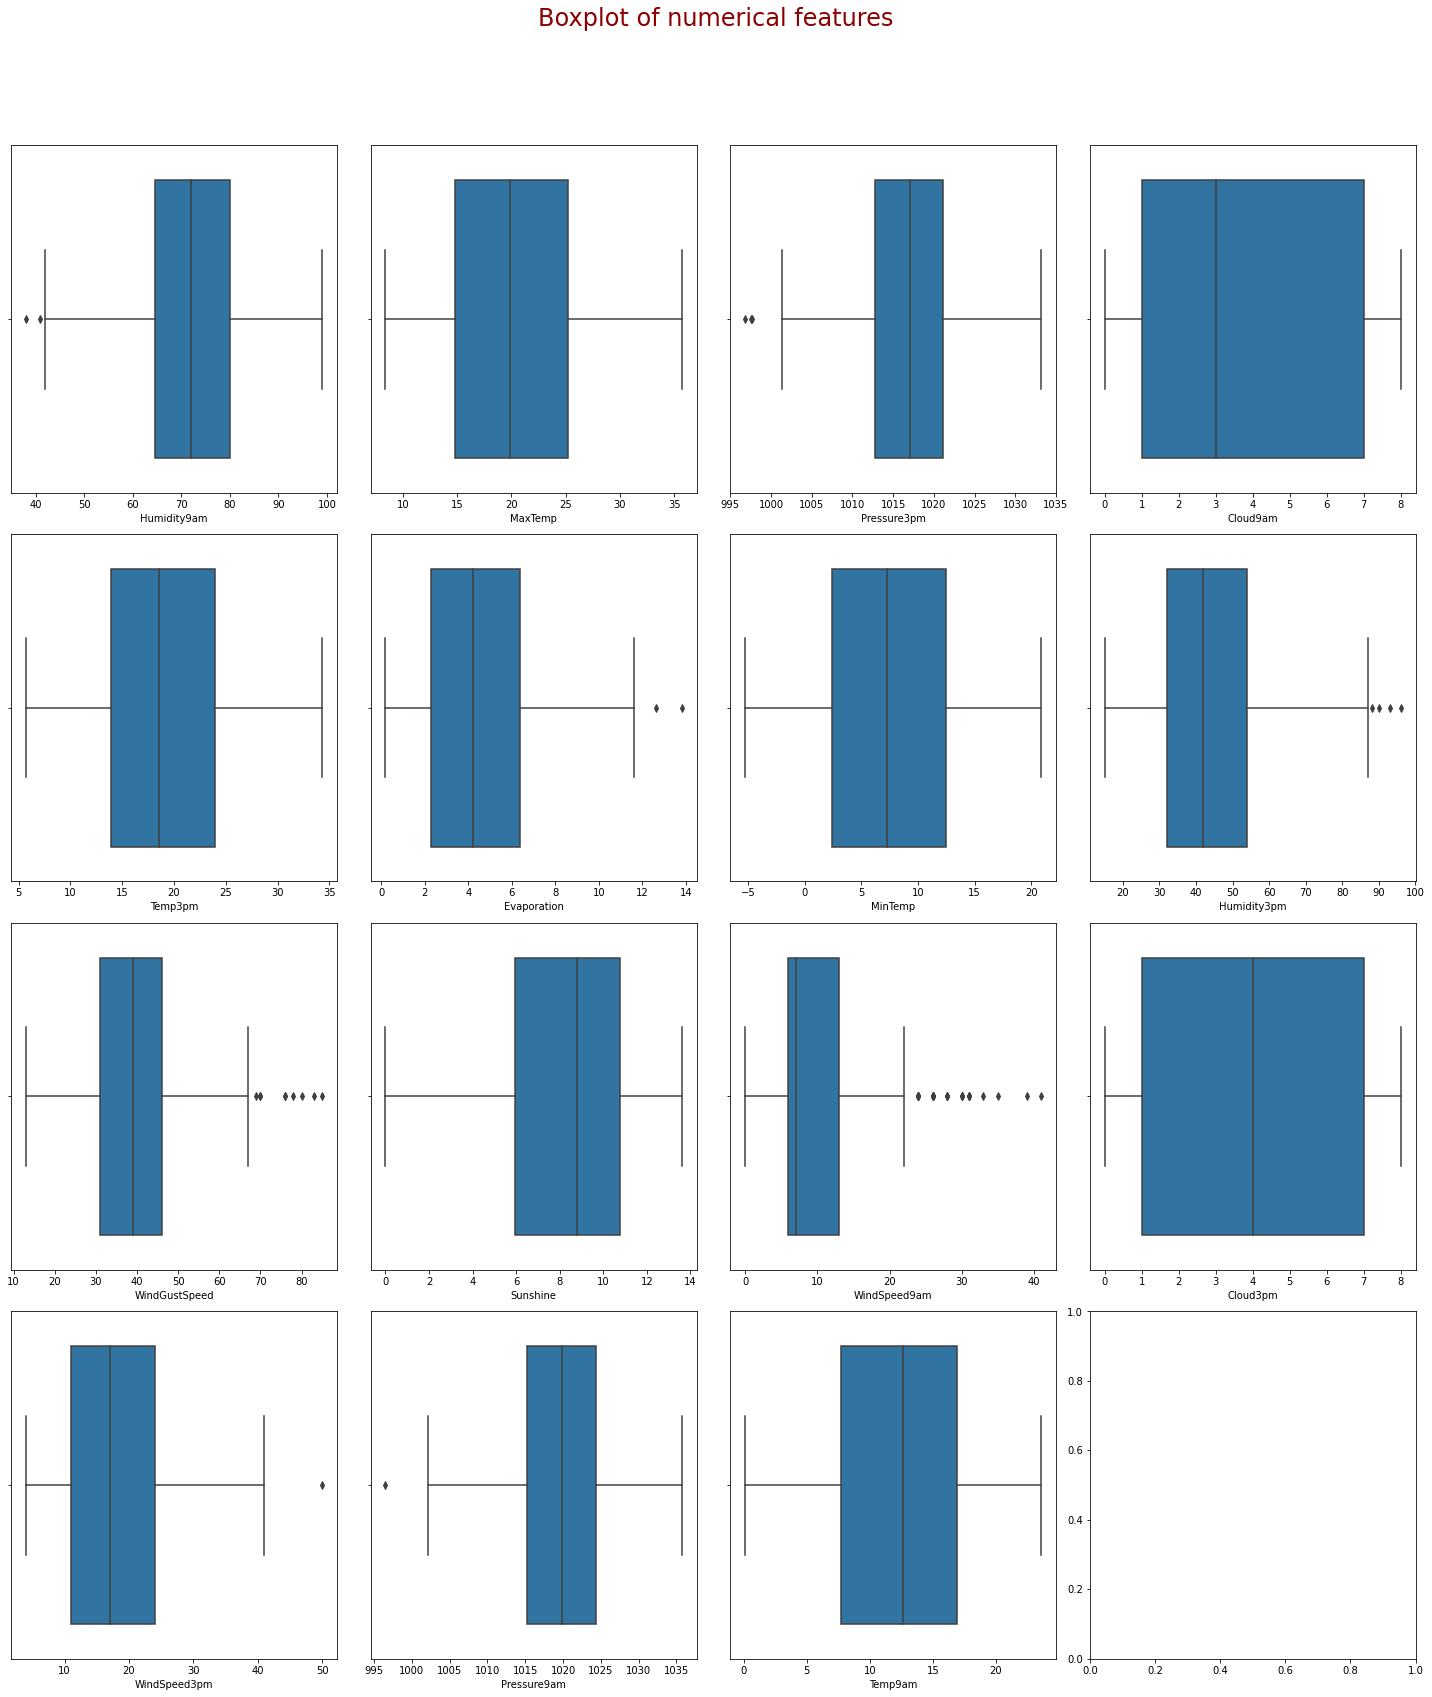

In [26]:
Weather.visualize('boxplot')

In [27]:
outliers = Weather.checkOutliers(threshold=2.5)
outliers

{'Cloud3pm': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -14.0,
  'Upper Bound': 22.0},
 'Cloud9am': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -14.0,
  'Upper Bound': 22.0},
 'Evaporation': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -7.950000000000002,
  'Upper Bound': 16.650000000000002},
 'Humidity3pm': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -23.0,
  'Upper Bound': 109.0},
 'Humidity9am': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': 25.75,
  'Upper Bound': 118.75},
 'MaxTemp': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -11.199999999999996,
  'Upper Bound': 51.199999999999996},
 'MinTemp': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -22.724999999999998,
  'Upper Bound': 37.574999999999996},
 'Pressure3pm': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': 991.875,
  'Upper Bound': 1041.9750000000001},
 'Pressure9am': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound'

In [28]:
Weather.train_data[['WindGustSpeed', 'WindSpeed9am']].describe()

,WindGustSpeed,WindSpeed9am
count,279.000000,279.000000
mean,39.544803,9.688172
std,12.567113,7.854768
min,13.000000,0.000000
25%,31.000000,6.000000
50%,39.000000,7.000000
75%,46.000000,13.000000
max,85.000000,41.000000


### Close look at outliers

In [29]:
wind_gust_outliers = outliers['WindGustSpeed']['Above Upper']
print("wind_gust_outliers Upper Bound is: ", outliers['WindGustSpeed']['Upper Bound'])

wind_gust_outliers Upper Bound is:  83.5


In [30]:
Weather.train_data[['WindGustSpeed']].loc[wind_gust_outliers]

,WindGustSpeed
2,85.0


In [31]:
wind_speed_outliers = outliers['WindSpeed9am']['Above Upper']
print("wind_speed_outliers Upper Bound is: ", outliers['WindSpeed9am']['Upper Bound'])

wind_speed_outliers Upper Bound is:  30.5


In [32]:
Weather.train_data[['WindSpeed9am']].loc[wind_speed_outliers]

,WindSpeed9am
337,31.0
356,35.0
51,41.0
244,31.0
318,39.0
243,33.0
252,31.0


> Outliers seem not that extreme so will increase the threshold and remove the extrem ones only

In [33]:
Weather.handleOutliers(threshold=3)

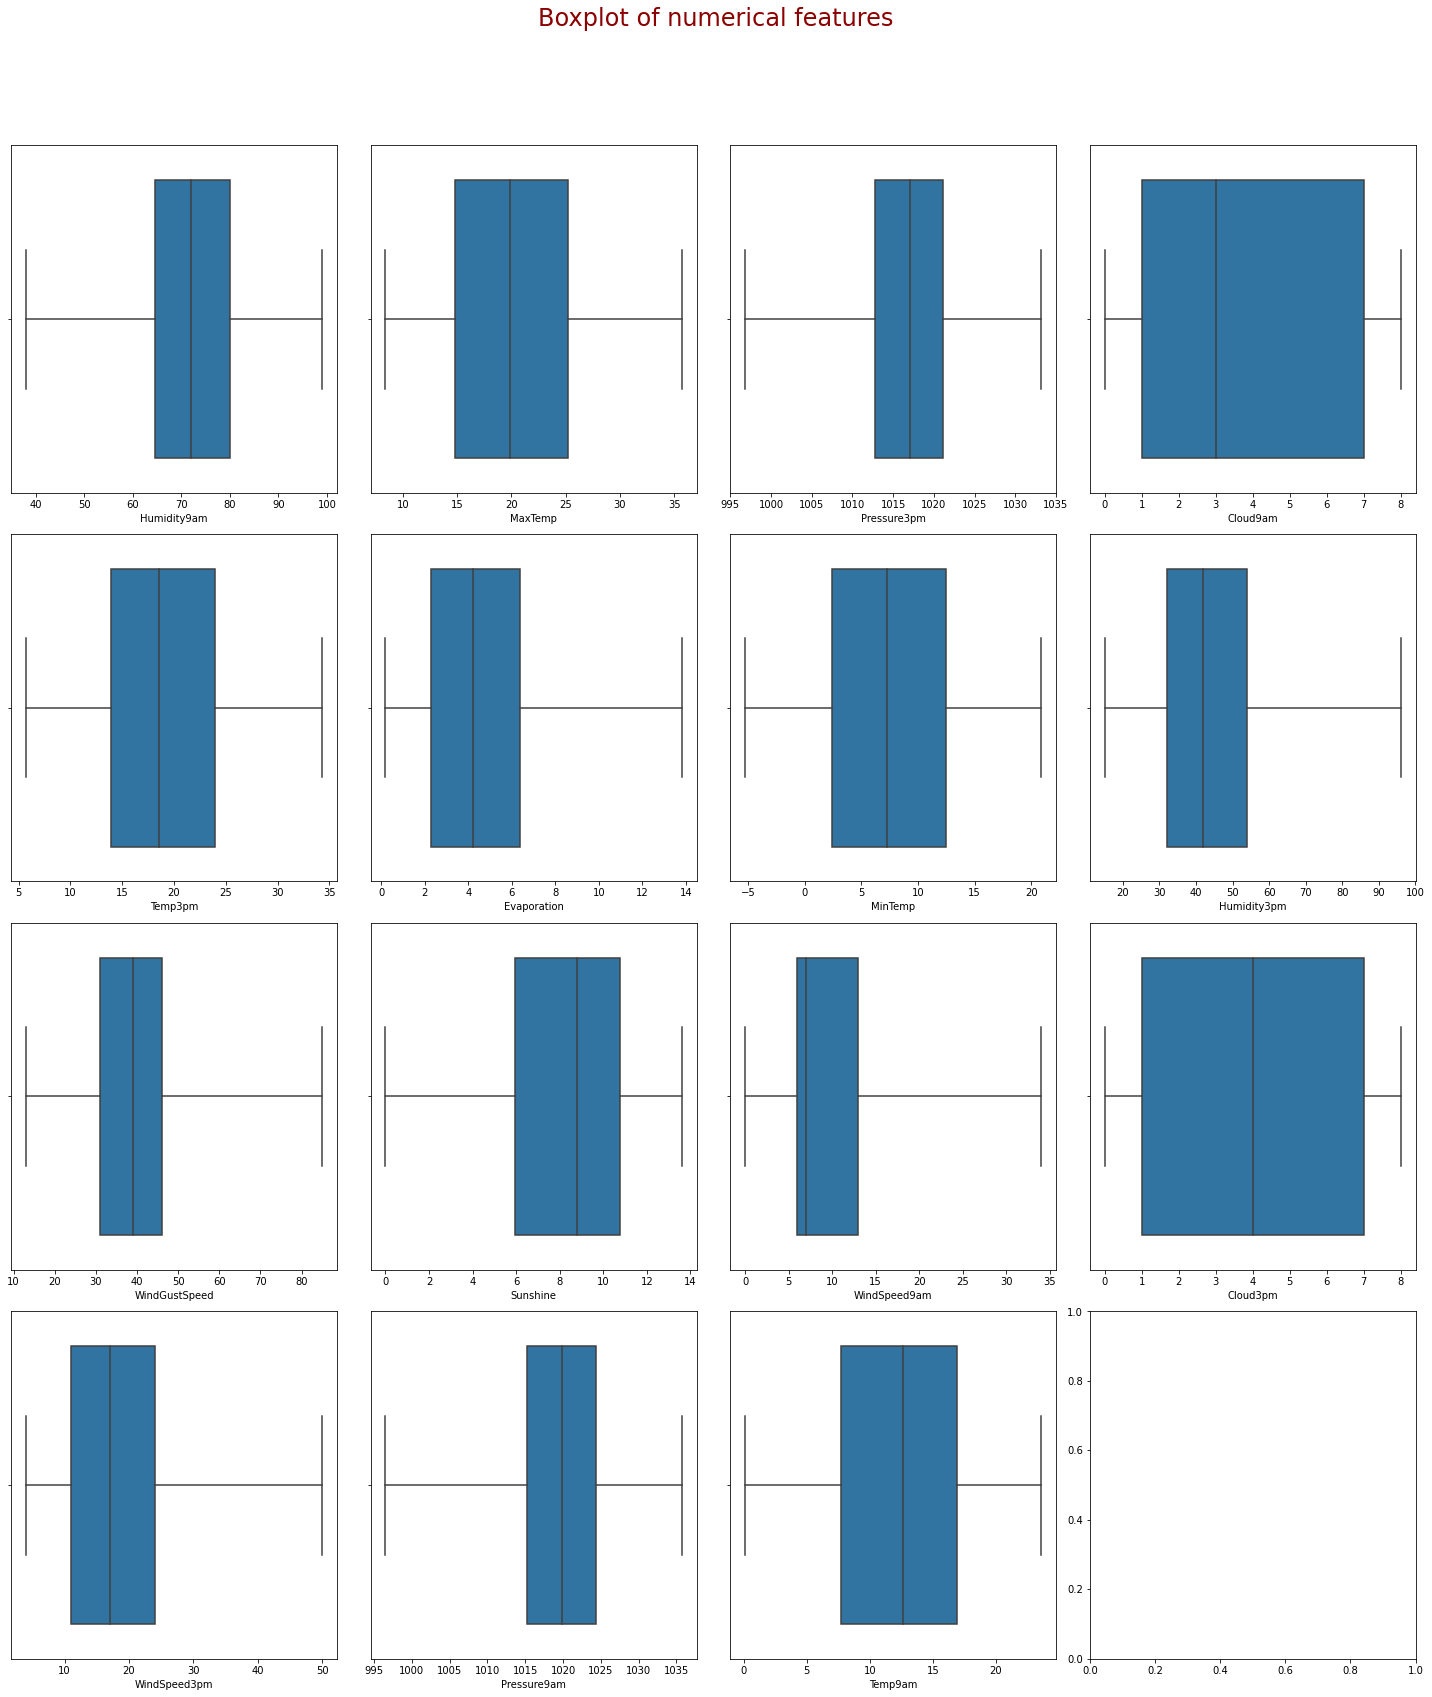

In [34]:
Weather.visualize('boxplot', whis=3)

## 4- Handle Correlation

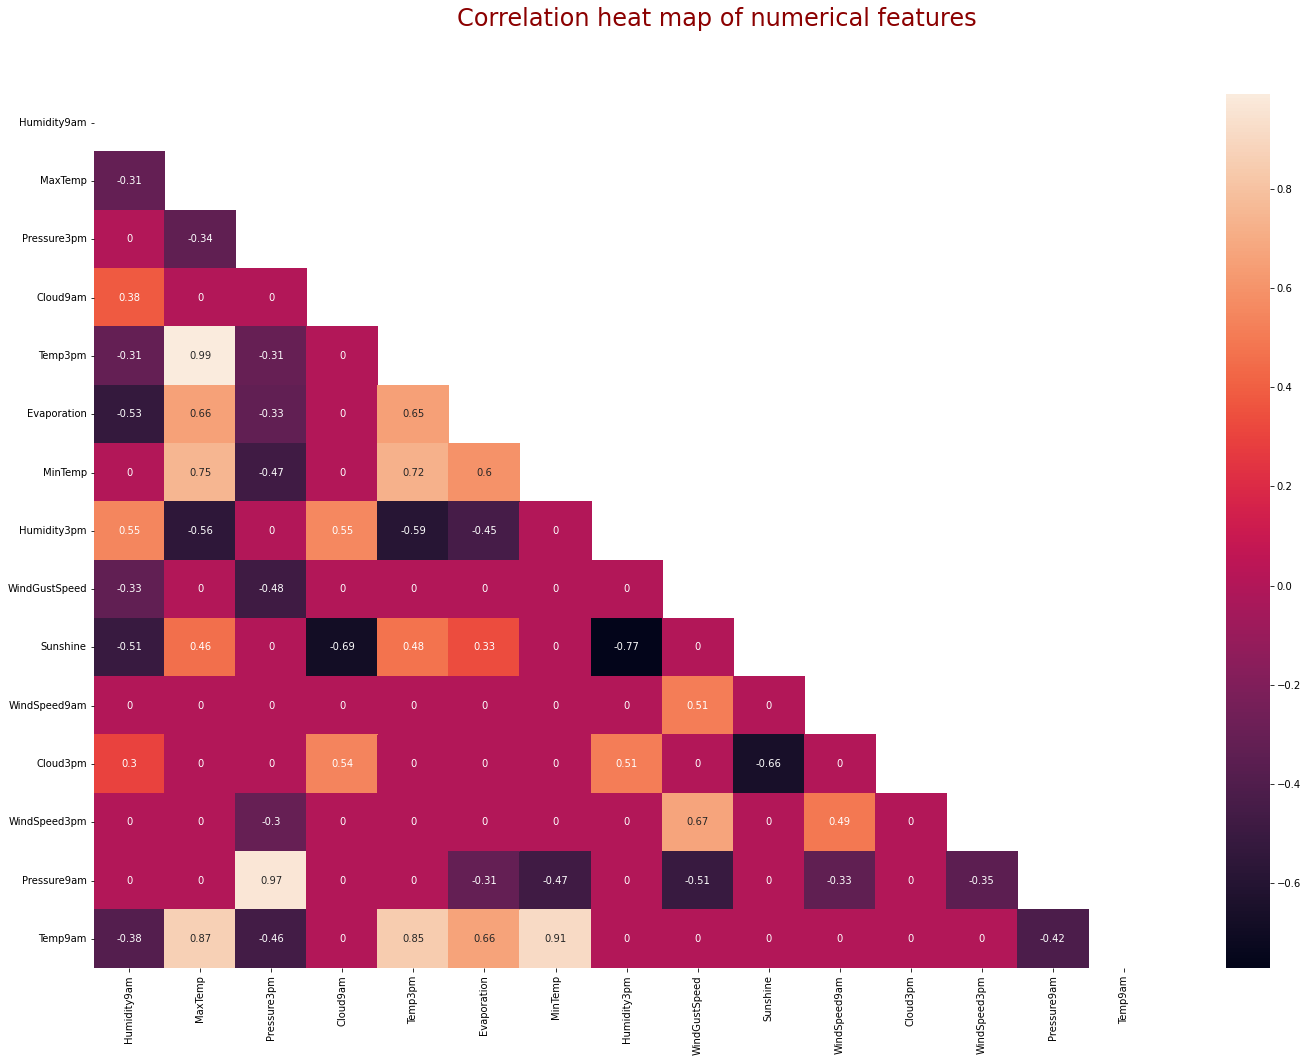

In [35]:
Weather.visualize('corr')

> I don't know a criteria to remove mutlicollinearity with classification as the target is not continuous. will try pca in later stages to over come mutli-collinearity.


1. I can drop one of them randomly and test results










## 5- Handle Skew

In [36]:
Weather.train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 100 to 156
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        279 non-null    float64
 1   MaxTemp        279 non-null    float64
 2   Evaporation    279 non-null    float64
 3   Sunshine       279 non-null    float64
 4   WindGustDir    279 non-null    object 
 5   WindGustSpeed  279 non-null    float64
 6   WindDir9am     279 non-null    object 
 7   WindDir3pm     279 non-null    object 
 8   WindSpeed9am   279 non-null    float64
 9   WindSpeed3pm   279 non-null    int64  
 10  Humidity9am    279 non-null    int64  
 11  Humidity3pm    279 non-null    int64  
 12  Pressure9am    279 non-null    float64
 13  Pressure3pm    279 non-null    float64
 14  Cloud9am       279 non-null    int64  
 15  Cloud3pm       279 non-null    int64  
 16  Temp9am        279 non-null    float64
 17  Temp3pm        279 non-null    float64
 18  RainToda

In [37]:
Weather.calcSkew(target=False)

,Skew Value
Humidity9am,-0.125208
MaxTemp,0.309754
Pressure3pm,-0.241393
Cloud9am,0.134886
Temp3pm,0.263949
Evaporation,0.714109
MinTemp,0.003287
Humidity3pm,0.703750
WindGustSpeed,0.793843
Sunshine,-0.758337


In [38]:
Weather.handleSkew(target=False)

In [39]:
Weather.calcSkew(target=False)

,Skew Value
Humidity9am,-0.125208
MaxTemp,0.309754
Pressure3pm,-0.241393
Cloud9am,0.134886
Temp3pm,0.263949
Evaporation,0.714109
MinTemp,0.003287
Humidity3pm,0.703750
WindGustSpeed,0.793843
Sunshine,-0.758337


## 6- Check Distribution

In [40]:
# gaussian feature, non Gaussian features
gaussian, nGaussian = Weather.checkDistribution(target=False)

W_Statistic=0.989, p=0.03255136
Humidity9am does not look Gaussian (reject H0)
W_Statistic=0.973, p=0.00003896
MaxTemp does not look Gaussian (reject H0)
W_Statistic=0.994, p=0.27564213
Pressure3pm looks like gaussian (fail to reject H0)
W_Statistic=0.820, p=0.00000000
Cloud9am does not look Gaussian (reject H0)
W_Statistic=0.980, p=0.00062802
Temp3pm does not look Gaussian (reject H0)
W_Statistic=0.950, p=0.00000003
Evaporation does not look Gaussian (reject H0)
W_Statistic=0.970, p=0.00001357
MinTemp does not look Gaussian (reject H0)
W_Statistic=0.962, p=0.00000103
Humidity3pm does not look Gaussian (reject H0)
W_Statistic=0.957, p=0.00000027
WindGustSpeed does not look Gaussian (reject H0)
W_Statistic=0.926, p=0.00000000
Sunshine does not look Gaussian (reject H0)
W_Statistic=0.928, p=0.00000000
WindSpeed9am does not look Gaussian (reject H0)
W_Statistic=0.857, p=0.00000000
Cloud3pm does not look Gaussian (reject H0)
W_Statistic=0.952, p=0.00000007
WindSpeed3pm does not look Gaussi

### Standard scale gaussian features and minmax non gaussian features

In [41]:
Weather.featureScale(target=False)

W_Statistic=0.989, p=0.03255136
Humidity9am does not look Gaussian (reject H0)
W_Statistic=0.973, p=0.00003896
MaxTemp does not look Gaussian (reject H0)
W_Statistic=0.994, p=0.27564213
Pressure3pm looks like gaussian (fail to reject H0)
W_Statistic=0.820, p=0.00000000
Cloud9am does not look Gaussian (reject H0)
W_Statistic=0.980, p=0.00062802
Temp3pm does not look Gaussian (reject H0)
W_Statistic=0.950, p=0.00000003
Evaporation does not look Gaussian (reject H0)
W_Statistic=0.970, p=0.00001357
MinTemp does not look Gaussian (reject H0)
W_Statistic=0.962, p=0.00000103
Humidity3pm does not look Gaussian (reject H0)
W_Statistic=0.957, p=0.00000027
WindGustSpeed does not look Gaussian (reject H0)
W_Statistic=0.926, p=0.00000000
Sunshine does not look Gaussian (reject H0)
W_Statistic=0.928, p=0.00000000
WindSpeed9am does not look Gaussian (reject H0)
W_Statistic=0.857, p=0.00000000
Cloud3pm does not look Gaussian (reject H0)
W_Statistic=0.952, p=0.00000007
WindSpeed3pm does not look Gaussi

In [42]:
Weather.train_data[gaussian].describe()

,Pressure3pm,Pressure9am
count,2.790000e+02,2.790000e+02
mean,7.799416e-15,-6.436906e-15
std,1.001797e+00,1.001797e+00
min,-3.151667e+00,-3.528262e+00
25%,-6.233963e-01,-6.564368e-01
50%,6.613199e-02,4.045945e-02
75%,7.001810e-01,7.373557e-01
max,2.618179e+00,2.475767e+00


In [43]:
Weather.train_data[nGaussian].describe()

,Humidity9am,MaxTemp,Cloud9am,Temp3pm,Evaporation,MinTemp,Humidity3pm,WindGustSpeed,Sunshine,WindSpeed9am,Cloud3pm,WindSpeed3pm,Temp9am
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,0.555849,0.443565,0.474014,0.473256,0.314253,0.480766,0.360414,0.368678,0.588657,0.591436,0.490591,0.301387,0.521620
std,0.212396,0.242471,0.373193,0.232363,0.193335,0.225195,0.206956,0.174543,0.261387,0.218242,0.331179,0.188189,0.234030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.434426,0.234432,0.125000,0.286713,0.154412,0.293893,0.209877,0.250000,0.437500,0.547319,0.125000,0.152174,0.325532
50%,0.557377,0.421245,0.375000,0.451049,0.294118,0.480916,0.333333,0.361111,0.647059,0.584877,0.500000,0.282609,0.531915
75%,0.688525,0.615385,0.875000,0.639860,0.455882,0.677481,0.481481,0.458333,0.790441,0.742278,0.875000,0.434783,0.714894
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
Weather.train_data.head()

,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
100,0.599237,0.457875,0.279412,0.654412,SSE,0.277778,S,S,0.779836,0.282609,0.442623,0.444444,-1.812825,-1.566544,0.750,0.750,0.582979,0.454545,No,No
94,0.854962,0.776557,0.411765,0.676471,E,0.486111,SE,ESE,0.647640,0.282609,0.475410,0.283951,-0.434349,-0.615471,0.750,0.875,0.919149,0.818182,No,Yes
49,0.683206,0.538462,0.102941,0.169118,NNW,0.236111,N,NW,0.452681,0.195652,0.967213,0.728395,-0.572197,-0.409405,1.000,0.875,0.646809,0.513986,Yes,Yes
316,0.183206,0.483516,0.352941,0.727941,NW,0.486111,NNE,NW,0.647640,0.478261,0.098361,0.148148,-0.755993,-0.916644,0.875,0.625,0.502128,0.552448,No,No
286,0.290076,0.139194,0.191176,0.720588,WNW,0.430556,WNW,NW,0.856322,0.565217,0.327869,0.320988,0.714381,0.906247,0.125,0.125,0.272340,0.164336,No,No


## 7- Categorical Feature encoding

In [45]:
cat_features = Weather.grabCategorical(target=False)
cat_features

['WindDir3pm', 'WindGustDir', 'RainToday', 'WindDir9am']

In [46]:
Weather.train_data['WindDir3pm'].value_counts()

NW     51
WNW    48
NNW    32
ESE    23
N      23
W      21
NE     14
E      12
S      10
NNE    10
WSW     9
SE      7
SSW     6
ENE     5
SSE     4
SW      4
Name: WindDir3pm, dtype: int64

In [47]:
Weather.train_data['WindDir9am'].value_counts()

SE     50
SSE    31
NNW    28
N      26
NW     24
ESE    23
S      20
WNW    15
E      15
SSW    15
NNE     7
ENE     7
W       6
SW      5
WSW     5
NE      2
Name: WindDir9am, dtype: int64

In [48]:
Weather.train_data['WindGustDir'].value_counts()

NW     54
NNW    36
WNW    29
E      28
ENE    24
N      19
ESE    19
W      15
S      15
NE     10
SSE     9
NNE     7
SE      7
SW      3
SSW     2
WSW     2
Name: WindGustDir, dtype: int64

In [49]:
Weather.train_data['RainToday'].value_counts()

No     226
Yes     53
Name: RainToday, dtype: int64

In [50]:
Weather.train_data[['WindGustDir', 'WindDir9am', 'WindDir3pm']].head(10)

,WindGustDir,WindDir9am,WindDir3pm
100,SSE,S,S
94,E,SE,ESE
49,NNW,N,NW
316,NW,NNE,NW
286,WNW,WNW,NW
187,NW,W,NW
148,W,SE,WNW
357,SSE,SSE,S
317,NW,N,NW
337,NNW,NW,NW


> Columns ['WindGustDir', 'WindDir9am', 'WindDir3pm'] seem to hold almost same value with different detail level so i will keep ['WindGustDir'] and remove other 2 columns

In [51]:
Weather.train_data['WindGustDir']

100    SSE
94       E
49     NNW
316     NW
286    WNW
      ... 
183      W
164      W
208    NNW
305     NW
156      E
Name: WindGustDir, Length: 279, dtype: object

In [52]:
# OneHotEncode
OHE = OneHotEncoder(sparse=False)
OHE = OHE.fit(Weather.train_data[['WindGustDir']])
OHE_train = OHE.transform(Weather.train_data[['WindGustDir']])
OHE_test = OHE.transform(Weather.test_data[['WindGustDir']])

In [53]:
# Ordinal Categories
train_ORD = Weather.train_data[['RainTomorrow']].replace({'No': 0, 'Yes': 1})
test_ORD = Weather.test_data[['RainTomorrow']].replace({'No': 0, 'Yes': 1})


## Train Data

In [54]:
cols = Weather.grabNumeric() + OHE.get_feature_names_out().tolist() + ['RainTomorrow']

In [55]:
train_num_cols = Weather.train_data[Weather.grabNumeric()].values
train_D = np.c_[train_num_cols, OHE_train, train_ORD]
final_train = pd.DataFrame(train_D, columns=cols)

In [56]:
final_train.shape

(279, 32)

## Test Data

In [57]:
test_num_cols = Weather.test_data[Weather.grabNumeric()].values
test_D = np.c_[test_num_cols, OHE_test, test_ORD]
final_test = pd.DataFrame(test_D, columns=cols)

In [58]:
final_test.shape

(63, 32)

# Model Testing

In [59]:
Train_x = final_train.drop(columns='RainTomorrow')
Train_y = final_train['RainTomorrow']

In [60]:
Test_x = final_test.drop(columns='RainTomorrow')
Test_y = final_test['RainTomorrow']

## Visualize class distribution

In [61]:
from sklearn.decomposition import PCA

pca = PCA(2)
x_new = pca.fit_transform(Train_x)

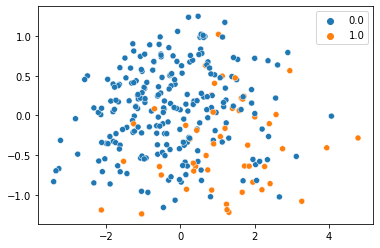

In [62]:
sns.scatterplot(x=x_new[:, 0], y=x_new[:, 1], hue=Train_y.values.ravel());

In [63]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [64]:
scaled_train = StandardScaler().fit(Train_x)

In [65]:
X_embded = TSNE(n_components=2, learning_rate='auto', perplexity=100, init='random').fit_transform(Train_x)

In [66]:
x = X_embded[:, 0]
y = X_embded[:, 1]

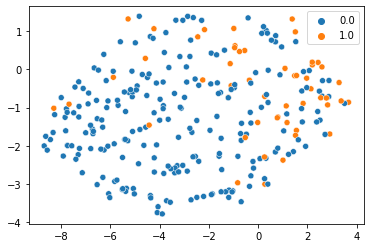

In [67]:
sns.scatterplot(x=x, y=y, hue=Train_y.values.ravel());

## Evaluation Metric

In [68]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

> Since we are predicting whether it will be rainning tomorrow or not then: 

*   Precision means how many days it will rain from the total number of days we predicted to be raining  
*   Recall means how many raining days we actually were able to predict as will be rainning

In this problem we are more interested in Recall as we want to predict as many rainning days as we can but also want our precision to be good not to say every day it will be raining and acheive 1 Recall.
F1-Score is a good measure to handle both cases Recall and trade off with Precision. But since target label is unblanced in the test set i will be using AUC as final judge.

## 1- Logistic Regression

### 1.1 Data with no PCA

In [69]:
Test_x.shape

(63, 31)

In [70]:
Train_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [71]:
Test_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [72]:
C = [.001, .01, .1, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]

for c in C:
    LR_Search = LogisticRegression(C=c, class_weight='balanced', max_iter=1000, fit_intercept=False)
    LR_Search.fit(Train_x, Train_y)

    # train y pred
    y_train_pred = LR_Search.predict(Train_x)

    # test y pred
    y_test_pred = LR_Search.predict(Test_x)

    # Precision
    train_precision = precision_score(Train_y, y_train_pred)
    test_precision = precision_score(Test_y, y_test_pred)

    # Recall
    train_recall = recall_score(Train_y, y_train_pred)
    test_recall = recall_score(Test_y, y_test_pred)

    # F1 score
    train_f1 = f1_score(Train_y, y_train_pred)
    test_f1 = f1_score(Test_y, y_test_pred)

    # Accuracy
    train_accuracy = accuracy_score(Train_y, y_train_pred)
    test_accuracy = accuracy_score(Test_y, y_test_pred)

    # append train results to train results df
    Train_results.loc[-1] = [c, True, 'Balanced', train_precision, train_recall, train_f1, train_accuracy]
    Train_results.index = Train_results.index + 1  # shifting index
    Train_results = Train_results.sort_index()

    # append test results to test results df
    Test_results.loc[-1] = [c, True, 'Balanced', test_precision, test_recall, test_f1, test_accuracy]
    Test_results.index = Test_results.index + 1  # shifting index
    Test_results = Test_results.sort_index()


In [73]:
Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
0,15.0,True,Balanced,0.661765,0.882353,0.756303,0.896057
1,14.0,True,Balanced,0.652174,0.882353,0.750000,0.892473
2,13.0,True,Balanced,0.652174,0.882353,0.750000,0.892473
3,12.0,True,Balanced,0.642857,0.882353,0.743802,0.888889
4,11.0,True,Balanced,0.628571,0.862745,0.727273,0.881720


In [74]:
Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
0,15.0,True,Balanced,0.5,0.916667,0.647059,0.809524
1,14.0,True,Balanced,0.5,0.916667,0.647059,0.809524
2,13.0,True,Balanced,0.5,0.916667,0.647059,0.809524
3,12.0,True,Balanced,0.5,0.916667,0.647059,0.809524
4,11.0,True,Balanced,0.5,0.916667,0.647059,0.809524


> Best Model ROC

In [75]:
LR_model = LogisticRegression(C=15, class_weight='balanced', max_iter=1000, fit_intercept=True)
LR_model.fit(Train_x, Train_y)

LogisticRegression(C=15, class_weight='balanced', max_iter=1000)

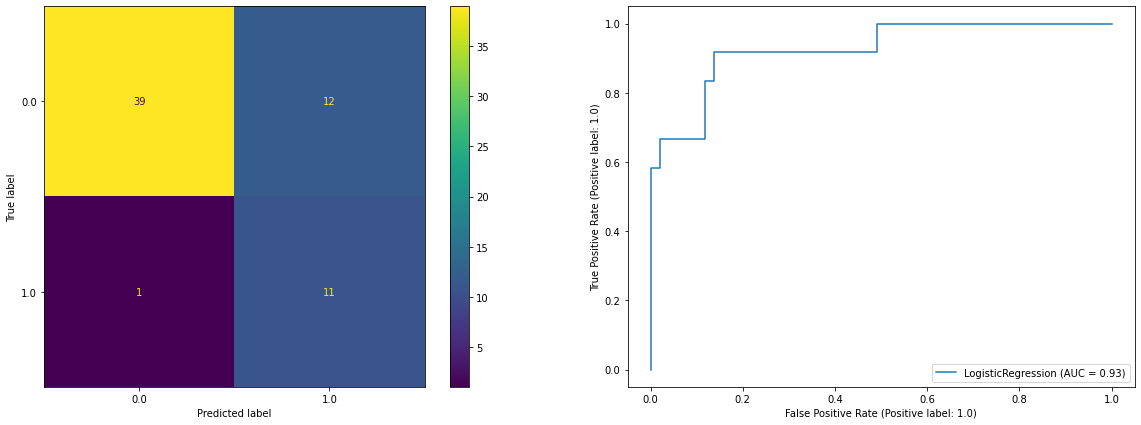

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(LR_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(LR_model, Test_x, Test_y, ax=axes[1]);

### 1.2 PCA

In [77]:
from sklearn.decomposition import PCA

In [78]:
pca = PCA(.9)
pca.fit(Train_x)
pca.n_components_

12

In [79]:
pca_train_x = pca.transform(Train_x)
pca_test_x = pca.transform(Test_x)

In [80]:
pca_Train_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [81]:
pca_Test_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [82]:
C = [.001, .01, .1, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]

for c in C:
    pca_LR_Search = LogisticRegression(C=c, class_weight='balanced', max_iter=1000, fit_intercept=False)
    pca_LR_Search.fit(pca_train_x, Train_y)

    # train y pred
    pca_y_train_pred = pca_LR_Search.predict(pca_train_x)

    # test y pred
    pca_y_test_pred = pca_LR_Search.predict(pca_test_x)

    # Precision
    pca_train_precision = precision_score(Train_y, pca_y_train_pred)
    pca_test_precision = precision_score(Test_y, pca_y_test_pred)

    # Recall
    pca_train_recall = recall_score(Train_y, pca_y_train_pred)
    pca_test_recall = recall_score(Test_y, pca_y_test_pred)

    # F1 score
    pca_train_f1 = f1_score(Train_y, pca_y_train_pred)
    pca_test_f1 = f1_score(Test_y, pca_y_test_pred)

    # Accuracy
    pca_train_accuracy = accuracy_score(Train_y, pca_y_train_pred)
    pca_test_accuracy = accuracy_score(Test_y, pca_y_test_pred)

    # append train results to train results df
    pca_Train_results.loc[-1] = [c, True, 'Balanced', pca_train_precision, pca_train_recall, pca_train_f1, pca_train_accuracy]
    pca_Train_results.index = pca_Train_results.index + 1  # shifting index
    pca_Train_results = pca_Train_results.sort_index()

    # append test results to test results df
    pca_Test_results.loc[-1] = [c, True, 'Balanced', pca_test_precision, pca_test_recall, pca_test_f1, pca_test_accuracy]
    pca_Test_results.index = pca_Test_results.index + 1  # shifting index
    pca_Test_results = pca_Test_results.sort_index()


In [83]:
pca_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
7,3.0,True,Balanced,0.370968,0.901961,0.525714,0.702509
8,2.0,True,Balanced,0.370968,0.901961,0.525714,0.702509
9,1.0,True,Balanced,0.370968,0.901961,0.525714,0.702509
0,15.0,True,Balanced,0.368000,0.901961,0.522727,0.698925
1,14.0,True,Balanced,0.368000,0.901961,0.522727,0.698925


In [84]:
pca_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
9,1.0,True,Balanced,0.413793,1.0,0.585366,0.730159
0,15.0,True,Balanced,0.400000,1.0,0.571429,0.714286
1,14.0,True,Balanced,0.400000,1.0,0.571429,0.714286
2,13.0,True,Balanced,0.400000,1.0,0.571429,0.714286
3,12.0,True,Balanced,0.400000,1.0,0.571429,0.714286


> ## PCA didn't give better results

## 2- SVC

In [85]:
from sklearn.svm import SVC

In [86]:
svc_Train_results = pd.DataFrame(columns=['Kernel', 'C', 'Degree', 'Gamma', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [87]:
svc_Test_results = pd.DataFrame(columns=['Kernel', 'C', 'Degree', 'Gamma', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [88]:
C = [.001, .01, .1, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]
degree = [2, 3, 4, 5, 6]
gamma = [.001, .01, .1, 1, 10]
kernel = ['rbf', 'poly', 'linear']


for k in kernel:
    if k == 'rbf':
        for c in C:
            for g in gamma:
                svc = SVC(class_weight='balanced', C=c, gamma=g, kernel=k)
                svc.fit(Train_x, Train_y)

                # train y pred
                svc_y_train_pred = svc.predict(Train_x)

                # test y pred
                svc_y_test_pred = svc.predict(Test_x)

                # Precision
                svc_train_precision = precision_score(Train_y, svc_y_train_pred)
                svc_test_precision = precision_score(Test_y, svc_y_test_pred)

                # Recall
                svc_train_recall = recall_score(Train_y, svc_y_train_pred)
                svc_test_recall = recall_score(Test_y, svc_y_test_pred)

                # F1 score
                svc_train_f1 = f1_score(Train_y, svc_y_train_pred)
                svc_test_f1 = f1_score(Test_y, svc_y_test_pred)

                # Accuracy
                svc_train_accuracy = accuracy_score(Train_y, svc_y_train_pred)
                svc_test_accuracy = accuracy_score(Test_y, svc_y_test_pred)

                # append train results to train results df
                svc_Train_results.loc[-1] = [k, c, -1, g, svc_train_precision, svc_train_recall, svc_train_f1, svc_train_accuracy]
                svc_Train_results.index = svc_Train_results.index + 1  # shifting index
                svc_Train_results = svc_Train_results.sort_index()

                # append test results to test results df
                svc_Test_results.loc[-1] = [k, c, -1, g, svc_test_precision, svc_test_recall, svc_test_f1, svc_test_accuracy]
                svc_Test_results.index = svc_Test_results.index + 1  # shifting index
                svc_Test_results = svc_Test_results.sort_index()
    elif k == 'linear':
        for c in C:
            svc = SVC(class_weight='balanced', C=c, kernel=k)
            svc.fit(Train_x, Train_y)

            # train y pred
            svc_y_train_pred = svc.predict(Train_x)

            # test y pred
            svc_y_test_pred = svc.predict(Test_x)

            # Precision
            svc_train_precision = precision_score(Train_y, svc_y_train_pred)
            svc_test_precision = precision_score(Test_y, svc_y_test_pred)

            # Recall
            svc_train_recall = recall_score(Train_y, svc_y_train_pred)
            svc_test_recall = recall_score(Test_y, svc_y_test_pred)

            # F1 score
            svc_train_f1 = f1_score(Train_y, svc_y_train_pred)
            svc_test_f1 = f1_score(Test_y, svc_y_test_pred)

            # Accuracy
            svc_train_accuracy = accuracy_score(Train_y, svc_y_train_pred)
            svc_test_accuracy = accuracy_score(Test_y, svc_y_test_pred)

            # append train results to train results df
            svc_Train_results.loc[-1] = [k, c, -1, -1, svc_train_precision, svc_train_recall, svc_train_f1, svc_train_accuracy]
            svc_Train_results.index = svc_Train_results.index + 1  # shifting index
            svc_Train_results = svc_Train_results.sort_index()

            # append test results to test results df
            svc_Test_results.loc[-1] = [k, c, -1, -1, svc_test_precision, svc_test_recall, svc_test_f1, svc_test_accuracy]
            svc_Test_results.index = svc_Test_results.index + 1  # shifting index
            svc_Test_results = svc_Test_results.sort_index()
    else:
        for c in C:
            for g in gamma:
                for d in degree:
                    svc = SVC(class_weight='balanced', C=c, gamma=g, kernel=k, degree=d)
                    svc.fit(Train_x, Train_y)

                    # train y pred
                    svc_y_train_pred = svc.predict(Train_x)

                    # test y pred
                    svc_y_test_pred = svc.predict(Test_x)

                    # Precision
                    svc_train_precision = precision_score(Train_y, svc_y_train_pred)
                    svc_test_precision = precision_score(Test_y, svc_y_test_pred)

                    # Recall
                    svc_train_recall = recall_score(Train_y, svc_y_train_pred)
                    svc_test_recall = recall_score(Test_y, svc_y_test_pred)

                    # F1 score
                    svc_train_f1 = f1_score(Train_y, svc_y_train_pred)
                    svc_test_f1 = f1_score(Test_y, svc_y_test_pred)

                    # Accuracy
                    svc_train_accuracy = accuracy_score(Train_y, svc_y_train_pred)
                    svc_test_accuracy = accuracy_score(Test_y, svc_y_test_pred)

                    # append train results to train results df
                    svc_Train_results.loc[-1] = [k, c, d, g, svc_train_precision, svc_train_recall, svc_train_f1, svc_train_accuracy]
                    svc_Train_results.index = svc_Train_results.index + 1  # shifting index
                    svc_Train_results = svc_Train_results.sort_index()

                    # append test results to test results df
                    svc_Test_results.loc[-1] = [k, c, d, g, svc_test_precision, svc_test_recall, svc_test_f1, svc_test_accuracy]
                    svc_Test_results.index = svc_Test_results.index + 1  # shifting index
                    svc_Test_results = svc_Test_results.sort_index()


> -1 in degree or coef0 mean not applicable with that type of kernel

In [89]:
svc_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Kernel,C,Degree,Gamma,Precision,Recall,F1-Score,Accuracy
13,poly,15.0,6,10.0,1.0,1.0,1.0,1.0
14,poly,15.0,5,10.0,1.0,1.0,1.0,1.0
15,poly,15.0,4,10.0,1.0,1.0,1.0,1.0
16,poly,15.0,3,10.0,1.0,1.0,1.0,1.0
17,poly,15.0,2,10.0,1.0,1.0,1.0,1.0


In [90]:
svc_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Kernel,C,Degree,Gamma,Precision,Recall,F1-Score,Accuracy
9,linear,1.0,-1,-1.00,0.545455,1.000000,0.705882,0.84127
351,rbf,13.0,-1,0.01,0.550000,0.916667,0.687500,0.84127
356,rbf,12.0,-1,0.01,0.550000,0.916667,0.687500,0.84127
10,linear,0.1,-1,-1.00,0.555556,0.833333,0.666667,0.84127
252,poly,1.0,2,0.10,0.555556,0.833333,0.666667,0.84127


> Best Model ROC

In [91]:
svc_model = SVC(C=1, kernel='linear', class_weight='balanced')
svc_model.fit(Train_x, Train_y)

SVC(C=1, class_weight='balanced', kernel='linear')

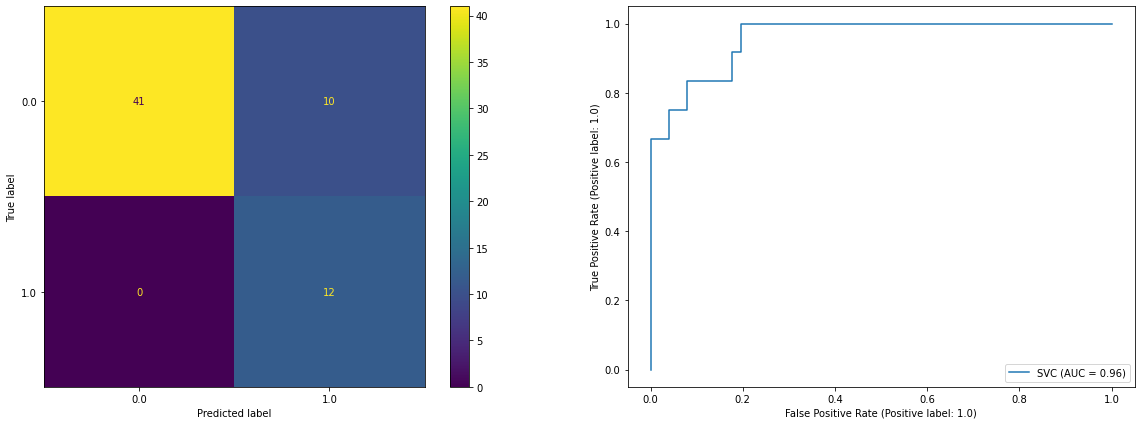

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(svc_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(svc_model, Test_x, Test_y, ax=axes[1]);

## 3- Decision Trees

In [93]:
Train_x.shape

(279, 31)

In [94]:
from sklearn.tree import DecisionTreeClassifier

In [95]:
tree_Train_results = pd.DataFrame(columns=['Max_Depth', 'Max_Features', 'Max_Leaf_Nodes', 'Min_sample_split', 'CCP_Alpha', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [96]:
tree_Test_results = pd.DataFrame(columns=['Max_Depth', 'Max_Features', 'Max_Leaf_Nodes', 'Min_sample_split', 'CCP_Alpha', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [97]:
max_depth = [3, 5, 7, 9, 12]
max_features = [2, 4, 8, 16, 24, 31]
max_leaf_nodes = [10, 20, 30, 40, 50]
min_sample_split = [4, 8, 16, 24]
cc_alpha = [.001, .005, .01, .015, .02, .025, .03]

for d in max_depth:
    for mf in max_features:
        for mss in min_sample_split:
            for mln in max_leaf_nodes:
                for cca in cc_alpha:
                    DTC = DecisionTreeClassifier(max_depth=d, max_features=mf, max_leaf_nodes=mln,
                                                class_weight='balanced', min_samples_split=mss, ccp_alpha=cca)
                    
                    DTC.fit(Train_x, Train_y)

                    # tree train y pred
                    tree_y_train = DTC.predict(Train_x)

                    # test test y pred
                    tree_y_test = DTC.predict(Test_x)

                    # Precision
                    tree_train_precision = precision_score(Train_y, tree_y_train)
                    tree_test_precision = precision_score(Test_y, tree_y_test)

                    # Recall
                    tree_train_recall = recall_score(Train_y, tree_y_train)
                    tree_test_recall = recall_score(Test_y, tree_y_test)

                    # F1 score
                    tree_train_f1 = f1_score(Train_y, tree_y_train)
                    tree_test_f1 = f1_score(Test_y, tree_y_test)

                    # Accuracy
                    tree_train_accuracy = accuracy_score(Train_y, tree_y_train)
                    tree_test_accuracy = accuracy_score(Test_y, tree_y_test)

                    # append train results to train results df
                    tree_Train_results.loc[-1] = [d, mf, mln, mss, cca, tree_train_precision, tree_train_recall, tree_train_f1, tree_train_accuracy]
                    tree_Train_results.index = tree_Train_results.index + 1  # shifting index
                    tree_Train_results = tree_Train_results.sort_index()

                    # append test results to test results df
                    tree_Test_results.loc[-1] = [d, mf, mln, mss, cca, tree_test_precision, tree_test_recall, tree_test_f1, tree_test_accuracy]
                    tree_Test_results.index = tree_Test_results.index + 1  # shifting index
                    tree_Test_results = tree_Test_results.sort_index()

In [98]:
tree_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Max_Depth,Max_Features,Max_Leaf_Nodes,Min_sample_split,CCP_Alpha,Precision,Recall,F1-Score,Accuracy
111,12.0,31.0,50.0,4.0,0.001,1.0,1.0,1.0,1.0
118,12.0,31.0,40.0,4.0,0.001,1.0,1.0,1.0,1.0
125,12.0,31.0,30.0,4.0,0.001,1.0,1.0,1.0,1.0
265,12.0,24.0,30.0,4.0,0.001,1.0,1.0,1.0,1.0
1098,9.0,24.0,40.0,4.0,0.001,1.0,1.0,1.0,1.0


In [99]:
tree_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Max_Depth,Max_Features,Max_Leaf_Nodes,Min_sample_split,CCP_Alpha,Precision,Recall,F1-Score,Accuracy
1980,7.0,16.0,30.0,24.0,0.001,0.666667,0.833333,0.740741,0.888889
783,12.0,2.0,40.0,8.0,0.001,0.611111,0.916667,0.733333,0.873016
517,12.0,8.0,20.0,8.0,0.001,0.692308,0.750000,0.720000,0.888889
3986,3.0,4.0,10.0,16.0,0.015,0.692308,0.750000,0.720000,0.888889
2154,7.0,8.0,30.0,16.0,0.005,0.625000,0.833333,0.714286,0.873016


> Best Model ROC

In [100]:
DTC_model = DecisionTreeClassifier(max_depth=5, max_features=2, max_leaf_nodes=20, min_samples_split=4, ccp_alpha=.001, class_weight='balanced')
DTC_model.fit(Train_x, Train_y)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=5,
                       max_features=2, max_leaf_nodes=20, min_samples_split=4)

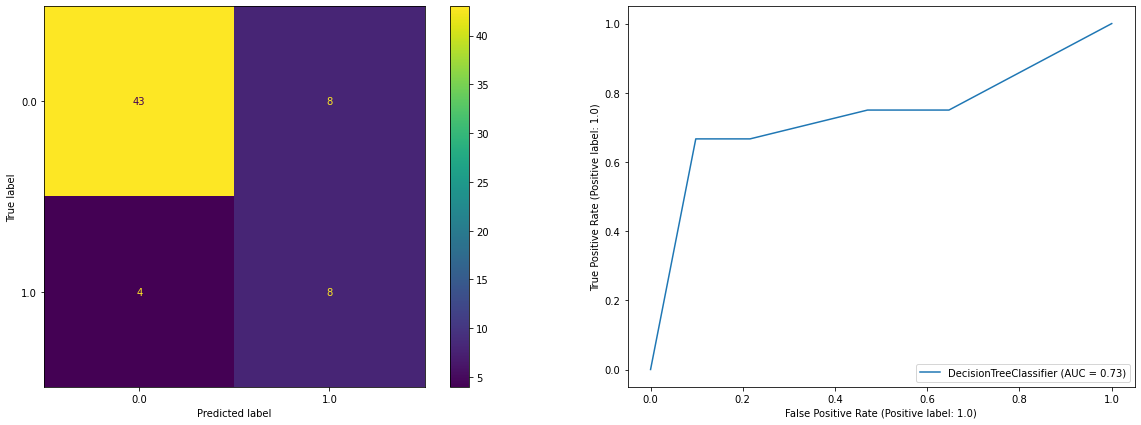

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(DTC_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(DTC_model, Test_x, Test_y, ax=axes[1]);

## 4- KNN

In [102]:
from sklearn.neighbors import KNeighborsClassifier

In [103]:
knn_Train_results = pd.DataFrame(columns=['N_Neighbors', 'Weights', 'Metric', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [104]:
knn_Test_results = pd.DataFrame(columns=['N_Neighbors', 'Weights', 'Metric', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [105]:
n_neighbors = [3, 5, 7, 9, 10, 15, 20]
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan', 'minkowski']

for n in n_neighbors:
    for w in weights:
        for m in metrics:
            knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
            knn.fit(Train_x, Train_y)

            # knn train y pred
            knn_Train_y = knn.predict(Train_x)

            # knn test y pred
            knn_Test_y = knn.predict(Test_x)

            # Precision
            knn_train_precision = precision_score(Train_y, knn_Train_y)
            knn_test_precision = precision_score(Test_y, knn_Test_y)

            # Recall
            knn_train_recall = recall_score(Train_y, knn_Train_y)
            knn_test_recall = recall_score(Test_y, knn_Test_y)

            # F1 score
            knn_train_f1 = f1_score(Train_y, knn_Train_y)
            knn_test_f1 = f1_score(Test_y, knn_Test_y)

            # Accuracy
            knn_train_accuracy = accuracy_score(Train_y, knn_Train_y)
            knn_test_accuracy = accuracy_score(Test_y, knn_Test_y)


            # append train results to train results df
            knn_Train_results.loc[-1] = [n, w, m, knn_train_precision, knn_train_recall, knn_train_f1, knn_train_accuracy]
            knn_Train_results.index = knn_Train_results.index + 1  # shifting index
            knn_Train_results = knn_Train_results.sort_index()

            # append test results to test results df
            knn_Test_results.loc[-1] = [n, w, m, knn_test_precision, knn_test_recall, knn_test_f1, knn_test_accuracy]
            knn_Test_results.index = knn_Test_results.index + 1  # shifting index
            knn_Test_results = knn_Test_results.sort_index()

In [106]:
knn_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,N_Neighbors,Weights,Metric,Precision,Recall,F1-Score,Accuracy
0,20,distance,minkowski,1.0,1.0,1.0,1.0
1,20,distance,manhattan,1.0,1.0,1.0,1.0
2,20,distance,euclidean,1.0,1.0,1.0,1.0
6,15,distance,minkowski,1.0,1.0,1.0,1.0
7,15,distance,manhattan,1.0,1.0,1.0,1.0


In [107]:
knn_Test_results.sort_values(['Recall', 'Precision'], ascending=False).head()

,N_Neighbors,Weights,Metric,Precision,Recall,F1-Score,Accuracy
0,20,distance,minkowski,0.833333,0.416667,0.555556,0.873016
2,20,distance,euclidean,0.833333,0.416667,0.555556,0.873016
19,9,distance,manhattan,0.833333,0.416667,0.555556,0.873016
22,9,uniform,manhattan,0.833333,0.416667,0.555556,0.873016
1,20,distance,manhattan,0.714286,0.416667,0.526316,0.857143


> Best Model ROC

In [108]:
KNN_model = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='minkowski')
KNN_model.fit(Train_x, Train_y)

KNeighborsClassifier(n_neighbors=20, weights='distance')

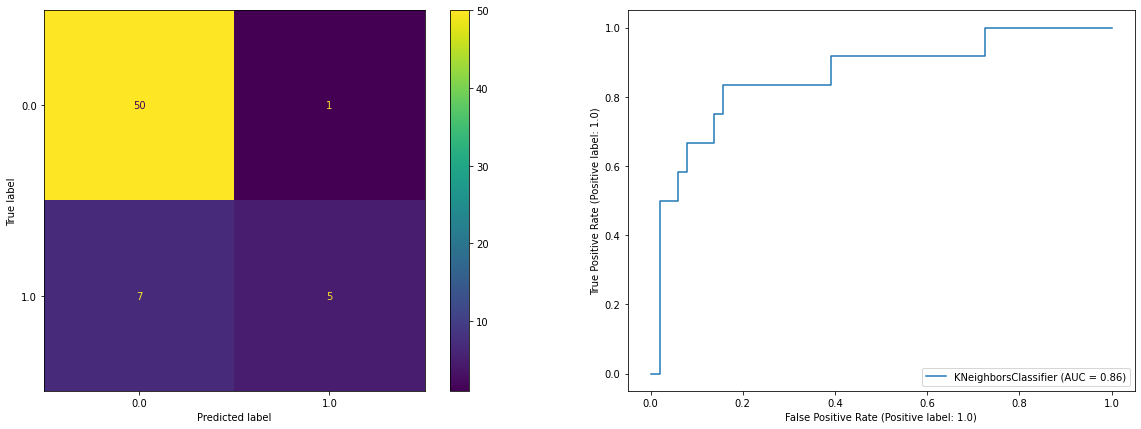

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(KNN_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(KNN_model, Test_x, Test_y, ax=axes[1]);

## Final conclusion

In [110]:
Final_Results = pd.DataFrame(columns=['Model', 'AUC', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [111]:
Final_Results.loc[-1] = ['Logistic', .93] + Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [112]:
Final_Results.loc[-1] = ['SVC', .96] + svc_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [113]:
Final_Results.loc[-1] = ['Tree', .73] + tree_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [114]:
Final_Results.loc[-1] = ['KNN', .86] + knn_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [115]:
Final_Results.sort_values(['F1-Score', 'Recall'], ascending=False)

,Model,AUC,Precision,Recall,F1-Score,Accuracy
1,Tree,0.73,0.666667,0.833333,0.740741,0.888889
2,SVC,0.96,0.545455,1.000000,0.705882,0.841270
3,Logistic,0.93,0.500000,0.916667,0.647059,0.809524
0,KNN,0.86,0.833333,0.416667,0.555556,0.873016


> SVC has the largest AUC  so it the best model as it made the lowest missclassification 